In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import pickle
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## Camera calibration

In [2]:
# camera calibration

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

imgpoints = []
objpoints = []

images = glob.glob('./camera_cal/calibration*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)


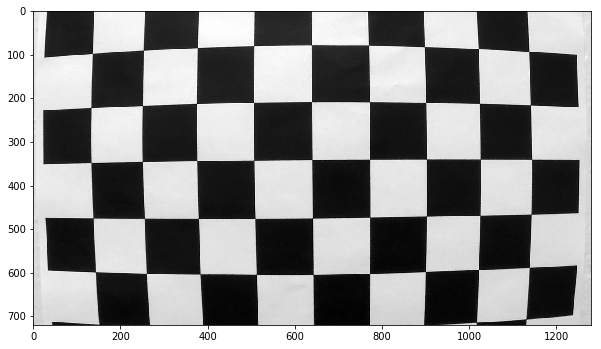

In [3]:
img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#print(img)
plt.imshow(img, cmap='gray')

(1280, 720)


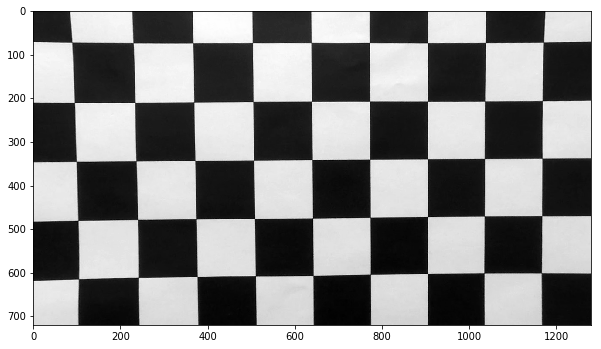

In [4]:
img_size = (img.shape[1], img.shape[0])
print(img_size)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
plt.imshow(dst, cmap='gray') # Undistorted Image

### Implement image undistortion in function

#### Function `imgUndistort(img, mtx, dist)`

In [5]:
def imgUndistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

#### Test and plot

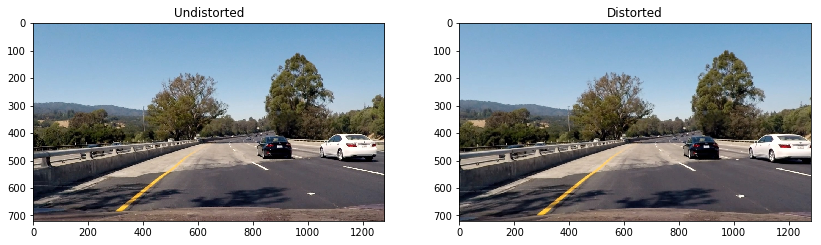

In [6]:
test_img = cv2.imread('test_images/test4.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

test_img_undist = imgUndistort(test_img, mtx, dist)

plt.rcParams['figure.figsize'] = (14, 8)
plt.figure()
plt.subplot(221)
plt.title("Undistorted")
plt.imshow(test_img)
plt.subplot(222)
plt.title("Distorted")
plt.imshow(test_img_undist)
plt.show()

## Perspective transformation

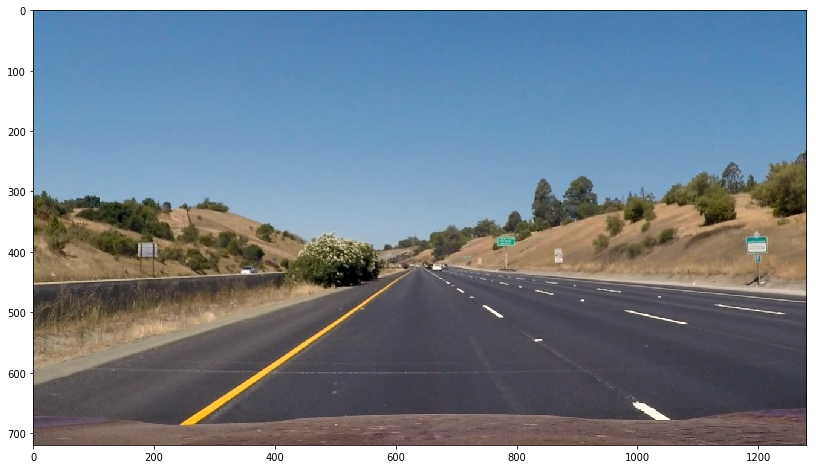

In [7]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Undistorted test image

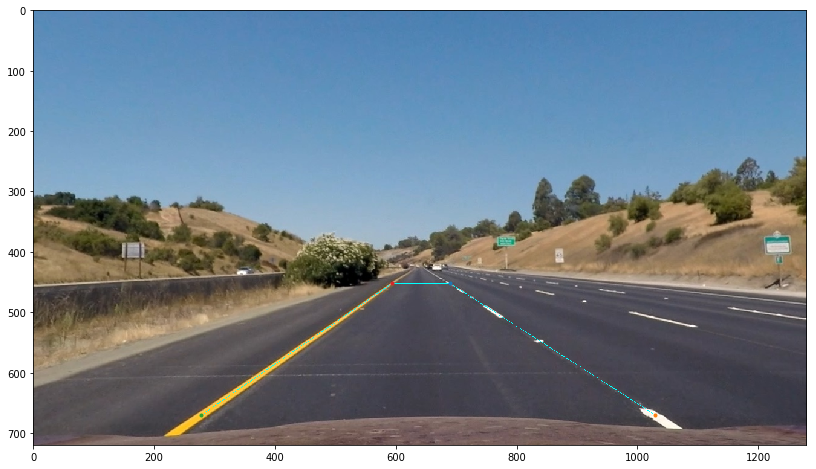

In [8]:
dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
dst = imgUndistort(img, mtx, dist)
pts = np.array([[689, 452],[1029, 670],[278, 670],[593, 452]], np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(dst,[pts],True,(0,255,255))
plt.plot(689, 452,'.')
plt.plot(1029, 670,'.')
plt.plot(278, 670,'.')
plt.plot(593, 452,'.')
plt.imshow(dst)

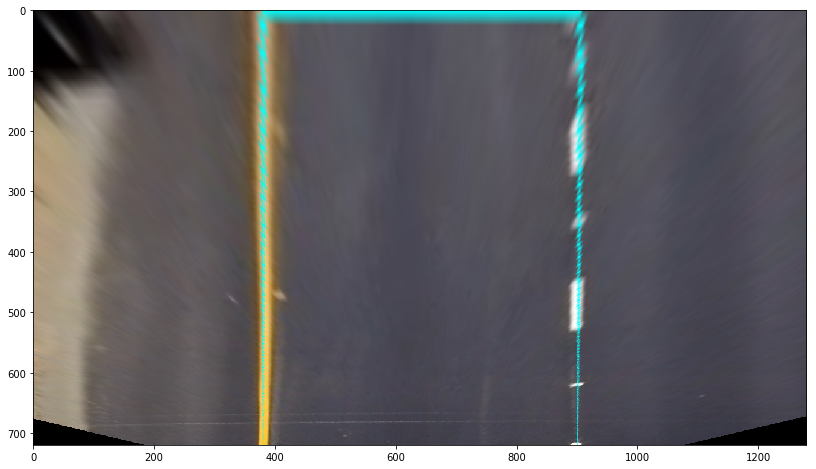

In [9]:
h,w = dst.shape[:2]
src_p = np.float32(
    [
        [688, 452],
        [1029, 670],
        [278, 670],
        [593, 452]
    ]
)

dst_p = np.float32(
    [
        [w-380, 0],
        [w-380, h],
        [380, h],
        [380, 0]
    ]
)

M = cv2.getPerspectiveTransform(src_p, dst_p)
Minv = cv2.getPerspectiveTransform(dst_p, src_p)

warped = cv2.warpPerspective(dst, M, (w,h), flags=cv2.INTER_LINEAR)
plt.imshow(warped)


### Implement perspective transformation in function

#### Function `getPerspectiveTransMatrix()` and `perspectiveTrans(img, M)`

In [10]:
def getPerspectiveTransMatrix():
    src_p = np.float32(
        [
            [688, 452],
            [1029, 670],
            [278, 670],
            [593, 452]
        ]
    )

    dst_p = np.float32(
        [
            [w-380, 0],
            [w-380, h],
            [380, h],
            [380, 0]
        ]
    )
    M = cv2.getPerspectiveTransform(src_p, dst_p)
    Minv = cv2.getPerspectiveTransform(dst_p, src_p)
    return M, Minv

def perspectiveTrans(img, M):
    h,w = img.shape[:2]
    return cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    

#### Test and plot

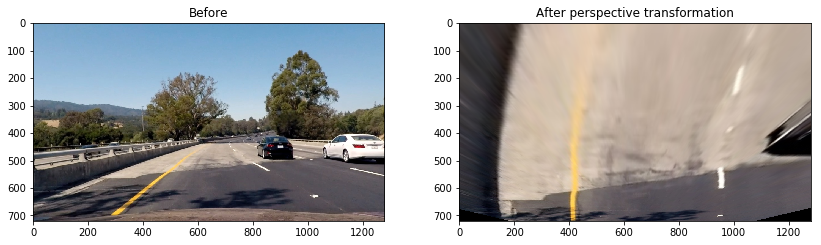

In [11]:
#test_img_undist
M, Minv = getPerspectiveTransMatrix()
test_img_pertrans = perspectiveTrans(test_img_undist, M)

plt.rcParams['figure.figsize'] = (14, 8)
plt.figure()
plt.subplot(221)
plt.title("Before")
plt.imshow(test_img_undist)
plt.subplot(222)
plt.title("After perspective transformation")
plt.imshow(test_img_pertrans)
plt.show()

## Color space and gradient thresholds
I'm going to try RGB, HSL and HSV to see which is better.

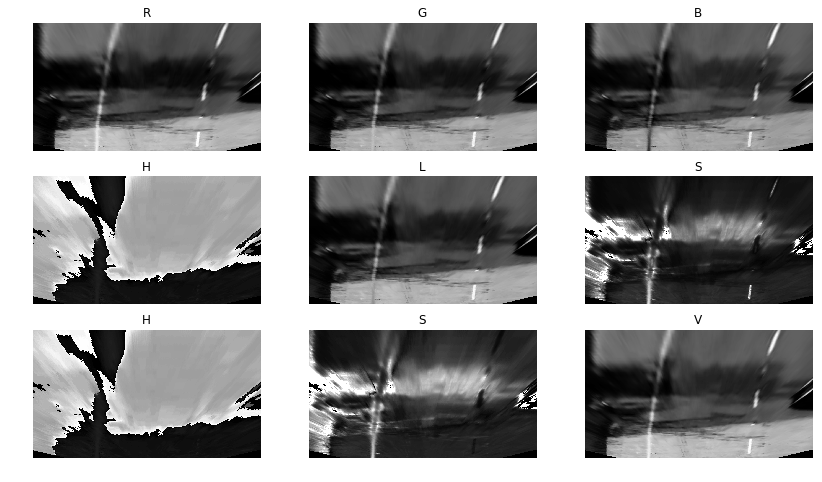

In [12]:
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img = imgUndistort(img, mtx, dist)
M,Minv = getPerspectiveTransMatrix()
img = perspectiveTrans(img, M)


RGB_img = img
HLS_img = cv2.cvtColor(RGB_img, cv2.COLOR_RGB2HLS)
HSV_img = cv2.cvtColor(RGB_img, cv2.COLOR_RGB2HSV)
a = HLS_img[:,:,0]

plt.figure()
plt.subplot(331)
plt.title('R')
plt.axis('off')
plt.imshow(RGB_img[:,:,0], cmap='gray')
plt.subplot(332)
plt.title('G')
plt.axis('off')
plt.imshow(RGB_img[:,:,1], cmap='gray')
plt.subplot(333)
plt.title('B')
plt.axis('off')
plt.imshow(RGB_img[:,:,2], cmap='gray')

plt.subplot(334)
plt.title('H')
plt.axis('off')
plt.imshow(HLS_img[:,:,0], cmap='gray')
plt.subplot(335)
plt.title('L')
plt.axis('off')
plt.imshow(HLS_img[:,:,1], cmap='gray')
plt.subplot(336)
plt.title('S')
plt.axis('off')
plt.imshow(HLS_img[:,:,2], cmap='gray')

plt.subplot(337)
plt.title('H')
plt.axis('off')
plt.imshow(HSV_img[:,:,0], cmap='gray')
plt.subplot(338)
plt.title('S')
plt.axis('off')
plt.imshow(HSV_img[:,:,1], cmap='gray')
plt.subplot(339)
plt.title('V')
plt.axis('off')
plt.imshow(HSV_img[:,:,2], cmap='gray')

plt.show()



### Thresholds

In [13]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Return the result
        return binary_output
    
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    """
    Returns an array of the same size as the input image of ones where gradients
    were in the threshold range, and zeros everywhere else.
    :param img: input image in BGR format.
    :param sobel_kernel: size of the sobel kernel to apply (must be odd number >= 3).
    :param thresh: threshold (0 to 255) for determining which gradients to include when creating binary output.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)/4
    # Calculate the magnitude of the gradient
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0-255) then convert to type = np.uint8
    scaled_gradmag = np.uint8(255*gradmag/np.max(gradmag))
    # Create a mask of 1's where the scaled gradient magnitude is within the given thresholds
    mag_binary = np.zeros_like(scaled_gradmag)
    mag_binary[(scaled_gradmag >= thresh[0]) & (scaled_gradmag <= thresh[1])] = 1
    # Return binary output image
    return mag_binary


def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Returns a binary image of the same size as the input image of ones where gradient directions
    were in the threshold range, and zeros everywhere else.
    :param img: input image in BGR format.
    :param sobel_kernel: size of the sobel kernel to apply (must be odd number >= 3).
    :param thresh: threshold (0 to pi/2) for determining which gradients to include when creating binary output.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate direction of gradient
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Create a mask of 1's where the gradient direction is within the given thresholds
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return binary output image
    return dir_binary


def color_thresh(img, r_thresh=(170, 255), s_thresh=(20, 100)):
    """
    Returns a binary image of the same size as the input image of ones where pixel values
    were in the threshold range, and zeros everywhere else.
    :param img: input image in BGR format.
    :param r_thresh: threshold (0 to 255) for determining which pixels from r_channel to include in binary output.
    :param s_thresh: threshold (0 to 255) for determining which pixels from s_channel to include in binary output.
    """
    # Apply a threshold to the R channel
    r_channel = img[:,:,2]
    r_binary = np.zeros_like(img[:,:,0])
    # Create a mask of 1's where pixel value is within the given thresholds
    r_binary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1

    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    # Create a mask of 1's where pixel value is within the given thresholds
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine two channels
    combined = np.zeros_like(img[:,:,0])
    combined[(s_binary == 1) & (r_binary == 1)] = 1
    #combined[(r_binary == 1)] = 1
    # Return binary output image
    return combined

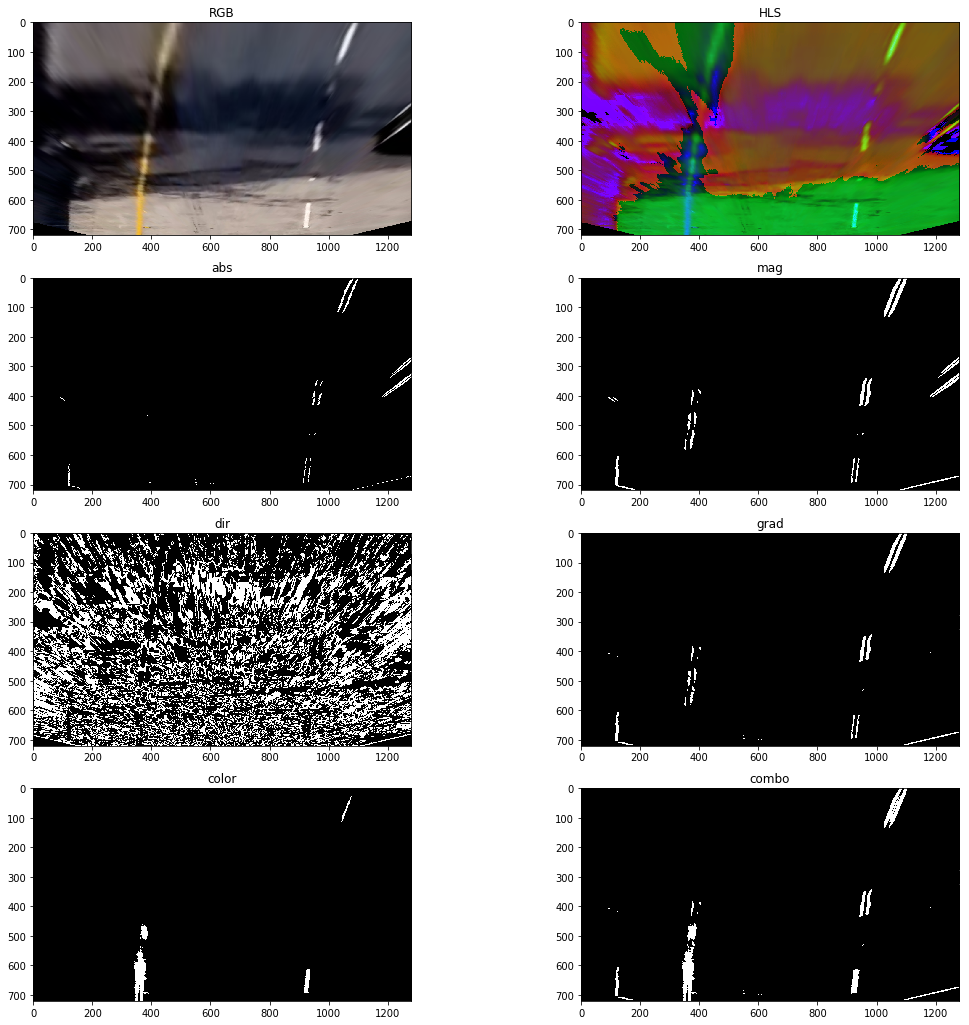

In [21]:
#import matplotlib.image as mpimg
#img = mpimg.imread('test_images/test4.jpg')
#thres_img = pipeline(HLS_img)

abs_binary = abs_sobel_thresh(RGB_img, orient='x', thresh_min=60, thresh_max=255)
mag_binary = mag_thresh(RGB_img, sobel_kernel=25, thresh=(75, 255))
dir_binary = dir_thresh(RGB_img, sobel_kernel=15, thresh=(0.7, 1.3))
grad_binary = np.zeros_like(RGB_img[:,:,0])
grad_binary[(((abs_binary == 1) | (mag_binary == 1)) & (dir_binary == 0))] = 1
color_binary = color_thresh(RGB_img, r_thresh=(60, 255), s_thresh=(80, 255))
combo_binary = np.zeros_like(RGB_img[:,:,0])
combo_binary[(grad_binary == 1) | (color_binary == 1)] = 255
#combo_binary[(grad_binary == 1)] = 255
#combo_binary[(color_binary == 1)] = 255

plt.rcParams['figure.figsize'] = (18,18)
plt.figure()
plt.subplot(421)
plt.title("RGB")
plt.imshow(RGB_img, cmap='gray')
plt.subplot(422)
plt.title("HLS")
plt.imshow(HLS_img, cmap='gray')
plt.subplot(423)
plt.title("abs")
plt.imshow(abs_binary, cmap='gray')
plt.subplot(424)
plt.title("mag")
plt.imshow(mag_binary, cmap='gray')
plt.subplot(425)
plt.title("dir")
plt.imshow(dir_binary, cmap='gray')
plt.subplot(426)
plt.title("grad")
plt.imshow(grad_binary, cmap='gray')
plt.subplot(427)
plt.title("color")
plt.imshow(color_binary, cmap='gray')
plt.subplot(428)
plt.title("combo")
plt.imshow(combo_binary, cmap='gray')
plt.show()

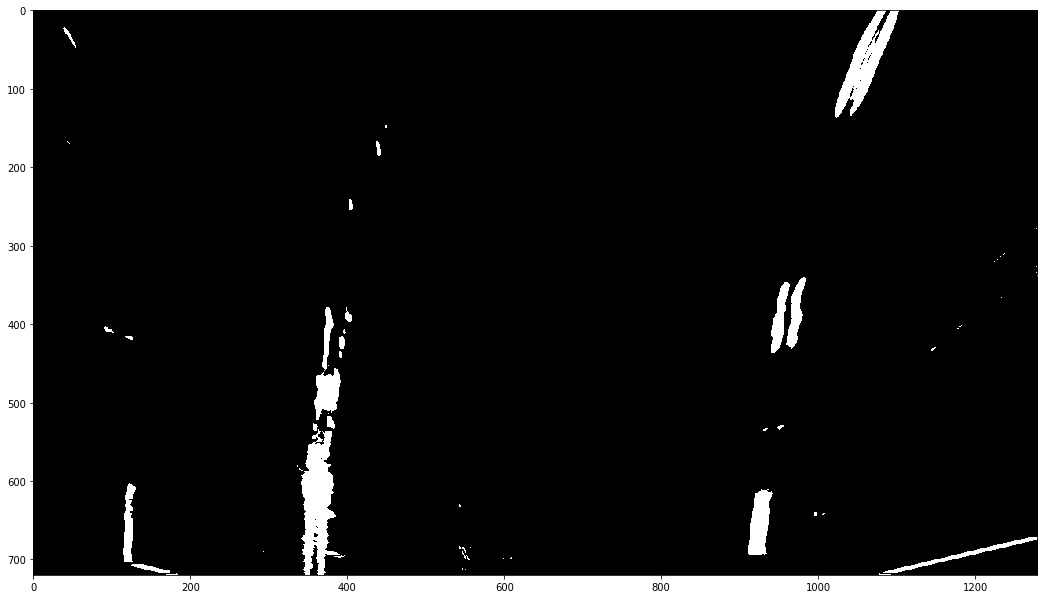

In [22]:
def combineThreshold(RGB_img):
    abs_binary = abs_sobel_thresh(RGB_img, orient='x', thresh_min=60, thresh_max=255)
    mag_binary = mag_thresh(RGB_img, sobel_kernel=25, thresh=(65, 255))
    dir_binary = dir_thresh(RGB_img, sobel_kernel=15, thresh=(0.7, 1.3))
    grad_binary = np.zeros_like(RGB_img[:,:,0])
    grad_binary[(((abs_binary == 1) | (mag_binary == 1)) & (dir_binary == 0))] = 1
    color_binary = color_thresh(RGB_img, r_thresh=(60, 255), s_thresh=(80, 255))
    combo_binary = np.zeros_like(RGB_img[:,:,0])
    combo_binary[(grad_binary == 1) | (color_binary == 1)] = 255
    return combo_binary

thres_img = combineThreshold(RGB_img)
plt.imshow(thres_img, cmap='gray')

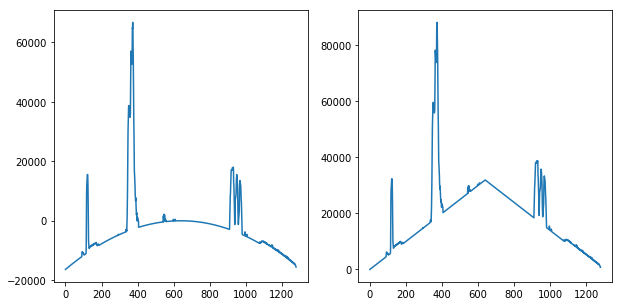

In [23]:
histogram = np.sum(thres_img[thres_img.shape[0]//2:,:], axis=0)
position_weights_quad = [-(x-thres_img.shape[1]/2)**2/25 for x in range(histogram.shape[0])]
position_weights_linear = np.zeros_like(histogram)
position_weights_linear[0:int(histogram.shape[0]/2)] = np.arange(0,histogram.shape[0]/2)
position_weights_linear[int(histogram.shape[0]/2):] = np.arange(histogram.shape[0]/2-1,-1,-1)
histogram_quad = histogram + position_weights_quad
histogram_linear = histogram + position_weights_linear * 50
plt.rcParams['figure.figsize'] = (10,5)
plt.figure()
plt.subplot(121)
plt.plot(histogram_quad)
plt.subplot(122)
plt.plot(histogram_linear)
plt.show()

In [24]:
def findLaneLine(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return leftx, lefty, left_fit, rightx, righty, right_fit

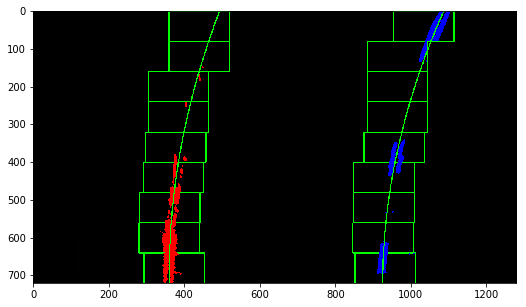

In [25]:
def findLaneLineWithBirdView(binary_warped):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    position_weights = [-(x-thres_img.shape[1]/2)**2/25 for x in range(histogram.shape[0])]
    histogram = histogram + position_weights
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 60
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #out_img[left_lane_inds, left_lane_inds] = [255, 0, 0]
    #out_img[right_lane_inds, right_lane_inds] = [0, 0, 255]

    binary_warped = thres_img
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    xpts = np.dstack((left_fitx, ploty)).reshape((720,2)).astype(np.int32)
    ypts = np.dstack((right_fitx, ploty)).reshape((720,2)).astype(np.int32)
    cv2.polylines(out_img, [xpts], False, (0,255,0), 2)
    cv2.polylines(out_img, [ypts], False, (0,255,0), 2)
    return out_img,leftx, lefty, left_fit, rightx, righty, right_fit

out_img,_,_,_,_,_,_ = findLaneLineWithBirdView(thres_img)
plt.imshow(out_img)
#plt.plot(left_fitx, ploty, color='yellow')
#plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)



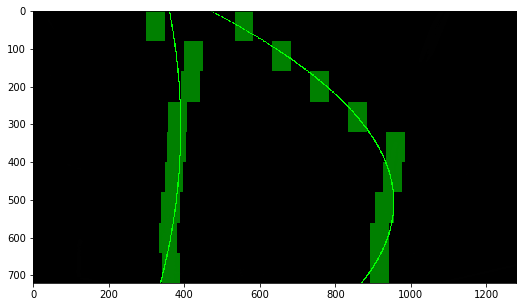

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

def binaryLaneBirdView_conv(warped):
    
    # window settings
    window_width = 50
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    def window_mask(width, height, img_ref, center, level):
        output = np.zeros_like(img_ref)
        output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
        return output

    def find_window_centroids(image, window_width, window_height, margin):

        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(image.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,image.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,image.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))

        return window_centroids

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    left_fit = np.array([0,0,0])
    right_fit = np.array([0,0,0])
    # If we found any window centers
    if len(window_centroids) > 0:
        
        # Fit the god damnned f**king dirty lane line
        lefty = [warped.shape[0] - i * window_height - int(window_height/2) for i in range(0,len(window_centroids))]
        righty = [warped.shape[0] - i * window_height - int(window_height/2) for i in range(0,len(window_centroids))]
        leftx = [window_centroids[i][0] for i in range(0,len(window_centroids))]
        rightx = [window_centroids[i][1] for i in range(0,len(window_centroids))]
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
        lpts = np.dstack((left_fitx, ploty)).reshape((720,2)).astype(np.int32)
        rpts = np.dstack((right_fitx, ploty)).reshape((720,2)).astype(np.int32)
        cv2.polylines(output, [lpts], False, (0,255,0), 2)
        cv2.polylines(output, [rpts], False, (0,255,0), 2)
        
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Return the final results
    return output

plt.imshow(binaryLaneBirdView_conv(thres_img))

In [27]:
'''
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
'''


'\ny_eval = np.max(ploty)\nleft_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])\nright_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])\nprint(left_curverad, right_curverad)\n'

In [28]:
'''
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
#print((ploty*ym_per_pix).shape, (leftx*xm_per_pix).shape)
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
'''


"\n# Define conversions in x and y from pixels space to meters\nym_per_pix = 30/720 # meters per pixel in y dimension\nxm_per_pix = 3.7/700 # meters per pixel in x dimension\n\n# Fit new polynomials to x,y in world space\n#print((ploty*ym_per_pix).shape, (leftx*xm_per_pix).shape)\nleft_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)\nright_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)\n# Calculate the new radii of curvature\nleft_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])\nright_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])\n# Now our radius of curvature is in meters\nprint(left_curverad, 'm', right_curverad, 'm')\n"

### Implement lane line visualization

In [29]:
def visLaneLine(undist, thres_img, Minv):
    birdview, leftx, lefty, left_fit, rightx, righty, right_fit = findLaneLineWithBirdView(thres_img)
    binary_warped = thres_img
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(thres_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Draw top-right overlay
    mini_birdview = np.zeros((int(birdview.shape[0]/3), int(birdview.shape[1]/3)))
    mini_birdview = cv2.resize(birdview, (mini_birdview.shape[1],mini_birdview.shape[0]))
    #result[:mini_birdview.shape[0],-mini_birdview.shape[1]:,:] = mini_birdview
    result[:mini_birdview.shape[0],-mini_birdview.shape[1]:,:] \
    = cv2.addWeighted(result[:mini_birdview.shape[0],-mini_birdview.shape[1]:,:], 1, mini_birdview, 0.9, 0)
    
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    #print((ploty*ym_per_pix).shape, (leftx*xm_per_pix).shape)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    # Now finding road center
    h = undist.shape[0]
    w = undist.shape[1]
    l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    lane_center = (r_fit_x_int + l_fit_x_int) /2
    
    bias = (w/2 - lane_center) * xm_per_pix
    if bias > 0:
        hud_center = "Vehicle is %.2f (m) right of center" % np.abs(bias)
    else:
        hud_center = "Vehicle is %.2f (m) left of center" % np.abs(bias)
    
    #radius = np.mean([left_curverad, right_curverad])
    hud_lradius = "Radius of left curvature =  %.2f (m)" % left_curverad
    hud_rradius = "Radius of right curvature =  %.2f (m)" % right_curverad
    
    font = cv2.FONT_HERSHEY_COMPLEX
    cv2.putText(result,hud_center,(10,40), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,hud_lradius,(10,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,hud_rradius,(10,160), font, 1,(255,255,255),2,cv2.LINE_AA)
    return result

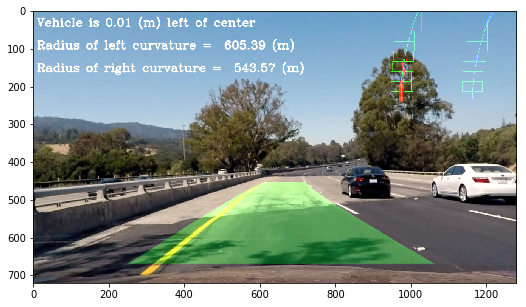

In [30]:
M, Minv = getPerspectiveTransMatrix()
found_result = visLaneLine(test_img_undist, thres_img, Minv)
#plt.imshow(found_result)

## Complete pipline

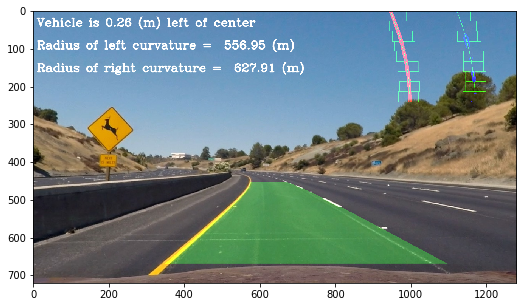

In [31]:
test_img = cv2.imread('test_images/test2.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

test_img_undist = imgUndistort(test_img, mtx, dist)

M, Minv = getPerspectiveTransMatrix()
test_img_pertrans = perspectiveTrans(test_img_undist, M)

thres_img = combineThreshold(test_img_pertrans)

found_result = visLaneLine(test_img_undist, thres_img, Minv)

plt.imshow(found_result)

### All-in-one function

In [32]:
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M, Minv = getPerspectiveTransMatrix()


def drawLaneLine(img):
    test_img_undist = imgUndistort(img, mtx, dist)
    test_img_pertrans = perspectiveTrans(test_img_undist, M)

    thres_img = combineThreshold(test_img_pertrans)

    vis_img = visLaneLine(test_img_undist, thres_img, Minv)
    
    return vis_img

def drawLaneLineBird(img):
    test_img_undist = imgUndistort(img, mtx, dist)
    test_img_pertrans = perspectiveTrans(test_img_undist, M)
    
    #HLS_img = cv2.cvtColor(test_img_pertrans,cv2.COLOR_RGB2HLS)
    thres_img = combineThreshold(test_img_pertrans)#pipeline(test_img_pertrans)

    vis_img = binaryLaneBirdView(thres_img)#visLaneLine(test_img_undist, thres_img, Minv)
    
    return vis_img


In [33]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

#sample_images = np.array(load_images_from_folder('test_images'))
#straight_lines_imgs = sample_images[0:2]
#test_imgs = sample_images[2:]

In [34]:
#plt.imshow(straight_lines_imgs[0])
#print(straight_lines_imgs.shape)
#print(test_imgs.shape)

cap = cv2.VideoCapture('challenge_video.mp4')
frames = []
while(True):
    ret, frame = cap.read()
    if ret == 0:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)
    
cap.release()

frames = np.array(frames)
print(frames.shape)

plt.imshow(frames[0])

In [35]:
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M, Minv = getPerspectiveTransMatrix()

from tqdm import tqdm 
#processed_frames = []
#for frame in tqdm(frames):
    #processed_frames.append(drawLaneLine(frame, mtx, dist, M, Minv))

In [36]:
'''
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('processed_roject.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (1280, 720))
for frame in processed_frames:
    out.write(frame)
out.release()
'''

from moviepy.editor import VideoFileClip
out_dir='./'
output = out_dir+'processed_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(drawLaneLine)
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████▉| 1260/1261 [03:23<00:00,  6.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

CPU times: user 4min 22s, sys: 8.51 s, total: 4min 31s
Wall time: 3min 23s
